In [1]:
%matplotlib inline
%autosave 60
import numpy as np
import pandas as pd
from glob import glob
import os
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator as kerasImageDataGenerator
import pickle

Autosaving every 60 seconds


Using TensorFlow backend.


In [2]:
# DEFINE FUNCTIONAL PARAMETERS
train_again = 0
split_and_organize = 0     # 1 to organize and split all images by label and to split train/validation, 0 if already done
print_model_graph = 1

# DEFINE PATHS
IMAGES_PATH = 'dataset\input\*.tif'
LABELS_PATH = r'dataset\train_labels.csv'
TRAINING_PATH = 'training'
VALIDATION_PATH = 'validation'
MODEL_CHECKPOINT_FILE = 'cancer_detector_nasnes.h5'
MODEL_HISTORY_FILE = 'cancer_detector_nasnes.h5'
TRAINING_LOGS_FILE = 'training_logs.csv'


# DEFINE HYPER-PARAMETERS
TRAINING_BATCH_SIZE = 32
LR_INITIAL = 0.0001
LR_DECAY = 0.00001
TRAINING_EPOCHS = 10

## Build Model

In [3]:
# from keras.applications.xception import Xception
# from keras.applications.nasnet import NASNetMobile
# from keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
# from keras.models import Model
# from keras.optimizers import Adam

# input_shape = (96, 96, 3)

# inputs = Input(input_shape)
# print("Loading NASNet Mobile...")
# nasnet = NASNetMobile(include_top=False, input_shape=input_shape)
# print("\rLoaded NASNet Mobile")
# x = nasnet(inputs)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
# outputs = Dense(1, activation='sigmoid')(x)

# model = Model(inputs, outputs)
# model.compile(optimizer=Adam(lr=LR_INITIAL, decay=LR_DECAY),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# print("Model built and compiled")
# model.summary()

In [4]:
# model.load_weights(MODEL_CHECKPOINT_FILE)

## Load Model and History + Plot Training history

In [5]:
from keras.models import load_model
from keras.optimizers import Adam

# LOAD AND COMPILE MODEL
model = load_model(MODEL_CHECKPOINT_FILE, compile=False)
model.compile(optimizer=Adam(lr=LR_INITIAL, decay=LR_DECAY),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
NASNet (Model)               (None, 3, 3, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1056)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 4,234,035
Non-trainable params: 36,738
_________________________________________________________________


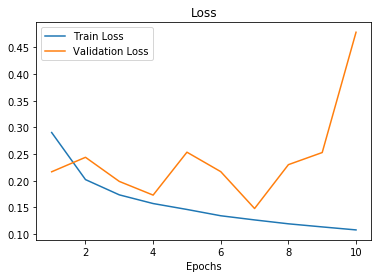

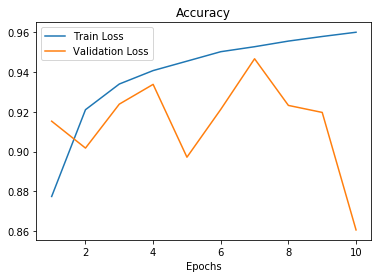

In [6]:
# TRAINING HISTORY (LOAD + PLOT)
with open('training_history.pkl', 'rb') as f:
    training_history = pickle.load(f)
    
epochs = [i for i in range(1, len(training_history['loss'])+1)]
plt.plot(epochs, training_history['loss'], label='Train Loss')
plt.plot(epochs, training_history['val_loss'], label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()

plt.plot(epochs, training_history['acc'], label='Train Loss')
plt.plot(epochs, training_history['val_acc'], label='Validation Loss')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Validation Performance: ROC, AUC

Found 17000 images belonging to 2 classes.
284/284 [==============================] - 34s 120ms/step


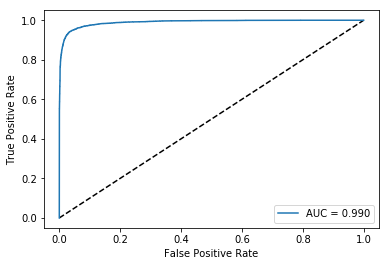

In [7]:
# Validation ROC (TP vs FP)
from sklearn.metrics import roc_curve, auc

roc_validation_generator = kerasImageDataGenerator(rescale=1./255)
roc_validation_generator = roc_validation_generator.flow_from_directory(VALIDATION_PATH,
                                                                        target_size=(96,96),
                                                                        batch_size=60,
                                                                        class_mode='binary',
                                                                        shuffle=False)

predictions_roc = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)

# Plot ROC Curve Validation dataset
FP, TP, thresh = roc_curve(roc_validation_generator.classes, predictions_roc)
AUC = auc(FP, TP)
plt.plot([0, 1], [0,1], 'k--')
plt.plot(FP, TP, label='AUC = {:.3f}'.format(AUC))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Test

In [8]:
import time
import psutil
import os
from skimage.io import imread 
from keras.backend import clear_session


TEST_BATCH = 5000
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0]/2.**30*1000  # memory use in GB...I think
print('Starting memory use: {} MB.'.format(memoryUse))  

test_files = glob('test/*.tif')
submission = pd.DataFrame()
print('Beginning.')

for idx in range(0, len(test_files), TEST_BATCH):
    if idx+TEST_BATCH > len(test_files)-1:
        ending = len(test_files)
    else:
        ending = idx+TEST_BATCH
        
    # 1. Put path on database
    data_frame = pd.DataFrame({'path': test_files[idx:ending]})
    # 2. Split path and add to ID column (apply a lambda split)
    data_frame['id'] = data_frame['path'].map(lambda x: x.split('\\')[1].split('.')[0])
    # 3. Load images
    t0 = time.time()
    data_frame['image'] = data_frame['path'].apply(imread)
    # 4. Stack images from batch [32,96,96,3]
    images = np.stack(data_frame.image, axis=0)
    # 5. Predict whole batch
    t0 = time.time()
    print("Batch: ({} - {})\n\t".format(idx, ending),end="")
    predictions = model.predict(images/255., verbose=1)
    predictions = [1 if x>=0.5 else 0 for x in predictions.ravel()]
    data_frame['label'] = predictions
    print('\tPrediction time: {:.2f} s'.format(time.time()-t0))

    # Save submission file
    submission = pd.concat([submission, data_frame[['id', 'label']]])

    # Print memory usage
    py = psutil.Process(pid)
    memoryPrev = memoryUse
    memoryUse = py.memory_info()[0]/2.**30*1000  # memory use in GB...I think
    print('\tMemory used: {:.2f} MB. Change: {:.2f} MB.'.format(memoryUse, memoryUse-memoryPrev))    
    
submission.set_index('id', inplace=True)
display(submission.head(10))
submission.to_csv('submission_file.csv')

Starting memory use: 2502.208709716797 MB.
Beginning.
Batch: (0 - 5000)
5000/5000 [==============================] - 12s 2ms/step
	Prediction time: 12.68 s
	Memory used: 2770.14 MB. Change: 267.93 MB.
Batch: (5000 - 10000)
5000/5000 [==============================] - 13s 3ms/step
	Prediction time: 13.89 s
	Memory used: 2771.37 MB. Change: 1.23 MB.
Batch: (10000 - 15000)
5000/5000 [==============================] - 16s 3ms/step
	Prediction time: 16.58 s
	Memory used: 2773.06 MB. Change: 1.69 MB.
Batch: (15000 - 20000)
5000/5000 [==============================] - 24s 5ms/step
	Prediction time: 24.43 s
	Memory used: 2774.12 MB. Change: 1.07 MB.
Batch: (20000 - 25000)
5000/5000 [==============================] - 33s 7ms/step
	Prediction time: 34.04 s
	Memory used: 2775.30 MB. Change: 1.17 MB.
Batch: (25000 - 30000)
5000/5000 [==============================] - 33s 7ms/step
	Prediction time: 34.11 s
	Memory used: 2776.45 MB. Change: 1.15 MB.
Batch: (30000 - 35000)
5000/5000 [================

,label
id,
00006537328c33e284c973d7b39d340809f7271b,1
0000ec92553fda4ce39889f9226ace43cae3364e,1
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
000253dfaa0be9d0d100283b22284ab2f6b643f6,0
000270442cc15af719583a8172c87cd2bd9c7746,0
000309e669fa3b18fb0ed6a253a2850cce751a95,0
000360e0d8358db520b5c7564ac70c5706a0beb0,0
00040095a4a671280aeb66cb0c9231e6216633b5,1
000698b7df308d75ec9559ef473a588c513a68aa,1


In [9]:
TEST_BATCH = 500
LEN = 5500
for idx in range(0, LEN, TEST_BATCH):
    if idx+TEST_BATCH-1 > LEN-1:
        ending = LEN-1
    else:
        ending = idx+TEST_BATCH-1
    print('{} - {}'.format(idx,ending))
a = [1, 2, 3, 4, 5, 6]
a[0:3]

0 - 499
500 - 999
1000 - 1499
1500 - 1999
2000 - 2499
2500 - 2999
3000 - 3499
3500 - 3999
4000 - 4499
4500 - 4999
5000 - 5499


[1, 2, 3]